In [1]:
import random
from tqdm import tqdm
import time
import pickle
import numpy as np
from itertools import chain
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel

import sys
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')
#sys.path.insert(0, '../src/visualization/')

from predict_model import loadBERT
from predict_model import SpanPredictor as classify
from build_features import text_cleaner
from build_features import get_prediction_results
#import visualize as vis

%matplotlib inline

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Load the model, tokenizer and external datasets

In [2]:
model = loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

CPU Success


In [3]:
test_agro = pickle.load(open('../data/processed/testing_web_trees_agroforestry.pkl', 'rb'))
test_llifle = pickle.load(open('../data/processed/testing_web_trees_llifle.pkl', 'rb'))

data = dict(test_agro) 
data.update(test_llifle)

## Get uncertain labels

In [4]:
# Undict the data
external_data = (list(chain.from_iterable(data.values())))

In [19]:
ones = Counter(ones[0] for ones in tqdm(external_data) if ones[0] == 1)
zeros = Counter(ones[0] for ones in tqdm(external_data) if ones[0] == 0)

print('{0} samples.'. format(len(external_data)))
print('{0} labels with 1 (true).'.format(ones[1]))
print('{0} labels with 0 (false).'.format(zeros[0]))

100%|██████████████████████████| 17204/17204 [00:00<00:00, 2019953.70it/s]

17204 samples.
771 labels with 1 (true).
16433 labels with 0 (false).


In [12]:
# Init emmty_list:
uncertain_list = []
# Arrays for plotting
yhat = np.array([]).reshape(0, 2)
y_onecold = np.array([])
# Sentence list
sentence_list = []

# loop over the values of the list
for (label, span) in tqdm(external_data):
    # Clean the sentence
    sentences = text_cleaner(span)
    # Loop over the sentences
    for sent in sentences:
        # Store for plotting
        sentence_list.append((label, sent))
        # Get predictions
        (pred_label, pred_value) = classify(sent, model=model, pred_values=True)
        # Store for plotting
        yhat = np.vstack([yhat, pred_value.numpy()])
        y_onecold = np.hstack([y_onecold, label])
        # Detach
        pred_value = pred_value[1].numpy().item()
        if  0.45 < pred_value < 0.55:
            # Append to list
            uncertain_list.append((pred_label, pred_value, sent))
            #print(pred_value, sent)

uncertain_list = list(set(uncertain_list))            

100%|█████████████████████████████| 17204/17204 [1:02:31<00:00,  4.59it/s]


In [13]:
with open('../data/processed/uncertain_sentences.pkl', 'wb') as f:
    pickle.dump(uncertain_list, f)
with open('../data/processed/external_testing_sentences.pkl', 'wb') as f:
    pickle.dump(sentence_list, f)

## Prediction on external dataset and Plotting

In [14]:
report, misclassified_sents, y_onehot = get_prediction_results(sentence_list, 
                                                                 model=model,
                                                                 soft_error=True, 
                                                                 beta=0.80)

100%|█████████████████████████████| 74836/74836 [1:00:31<00:00, 20.61it/s]


In [15]:
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     66051
         1.0       0.83      0.90      0.86      8785

    accuracy                           0.97     74836
   macro avg       0.91      0.94      0.92     74836
weighted avg       0.97      0.97      0.97     74836



### ROC

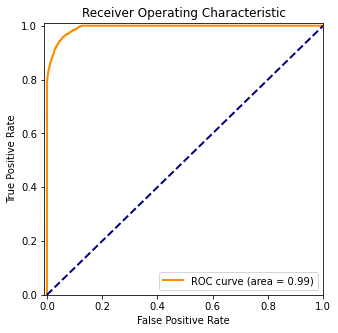

In [16]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fig, ax = plt.subplots(figsize=(5, 5))
#plt.figure()
lw = 2
ax.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('AUC-ROC_external.svg', format='svg', dpi=1200, bbox_inches='tight')

## Precision-recall curve

In [17]:
# Correct for beta
y_onecold_corrected = np.array([])
for label, prediction in zip(tqdm(y_onecold), yhat):
    if prediction[0] > 0.80:
        y_onecold_corrected = np.hstack([y_onecold_corrected, 0])
    elif prediction[1] > 0.80:
        y_onecold_corrected = np.hstack([y_onecold_corrected, 1])
    else:
        y_onecold_corrected = np.hstack([y_onecold_corrected, label])

100%|████████████████████████████| 74836/74836 [00:01<00:00, 52277.27it/s]


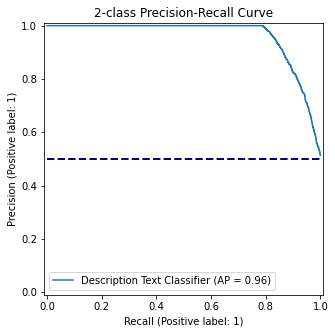

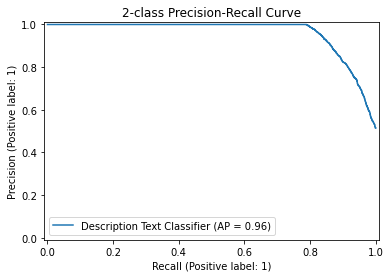

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
display = PrecisionRecallDisplay.from_predictions(y_onecold_corrected, yhat[:, 1], name="Description Text Classifier")
_ = display.ax_.set_title("2-class Precision-Recall Curve")
#display.plot(ax=ax)
display.ax_.set_xlim([-0.01, 1.01])
display.ax_.set_ylim([-0.01, 1.01])
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.plot([0, 1], [0.5, 0.5], color='navy', lw=lw, linestyle='--')
display.plot(ax=ax)
ax.set_title("2-class Precision-Recall Curve")
fig.savefig('precision_recall_plot_extern.svg', format='svg', dpi=1200, bbox_inches='tight')